In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from libcpab.libcpab.pytorch import cpab
from sklearn.metrics import average_precision_score
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display
from skimage.transform import resize
import datetime

----------------------------------------------------------------------
Operating system: linux
Using pytorch backend
----------------------------------------------------------------------


In [3]:
class FineGrainedDataset(Dataset):
    
    def __init__(self, csv_path,picture_path, picturesize, transform=True):
        """
        Construct Fine Grained Dataset.
        
        Args
            csv_path: Path to CSV file.
            picturesize: Dimensions of sample images.
            transform: 
        """
        self.transform = transform
        self.picturesize = picturesize
        
        # construct dataframe with onehot notation
        self.df = pd.get_dummies(pd.read_csv(csv_path))
        # create ID column with image file names
        self.df['id'] = self.df['image_id'].apply(lambda x: str(x)) + "_" + self.df['tag_id'].apply(lambda x: str(x)) + ".png"
        # only use class columns and id column
        self.df = self.df.iloc[:, 10:]
        
        #replace -1 with 0
        self.df = self.df.replace(to_replace=-1, value=0)
        
        self.path = picture_path
            
        
    def __getitem__(self, idx):
        """
        Support integer indexing on dataset (range 0 to len(self)).
        """
        sample_id = self.df['id'].iloc[idx]
        
        # get target values for sample
        targets = self.df.loc[idx, self.df.columns != 'id'].values.astype('float32')
        
        # get sample image
        image = np.asarray(Image.open(self.path + sample_id))
        
        # transform sample
        if self.transform:
            img = image
            img_normalized = np.copy(img)
            img_normalized = img_normalized / 255.
            
            img_resized = resize(img_normalized, output_shape=(self.picturesize,self.picturesize), mode='reflect', anti_aliasing=True)[:,:,:3]
            
            sample = {'id': sample_id, 'targets': torch.from_numpy(targets), 'image': torch.from_numpy(img_resized)}
        else:
            sample = {'id': sample_id, 'targets': targets, 'image': image}
        
        return sample
    
    def __len__(self):
        """
        Get length of dataset.
        """
        return len(self.df)
    

In [4]:
def train_valid_split(df, trainsplit_size=0.8):
    """
    Split a dataset in training- and validation split.

    Split is made by splitting the least represented class first
    and the highest represented class last.

    Function is made for multilabel problems where samples that are already 
    drawn from a previous class are not drawn again, and the ratio of the 
    split is calculated at each class from the previous draws to match the 
    split criteria.

    Args
        df: A dataframe which the split should be created from.
            The indexes should be the ID's of the samples.
        trainsplit_size: The size of the training split. 
                         Should be a float in the interval [0, 1]
    """
    # placeholders
    cls = {}
    train_idx = []
    valid_idx = []
    
    df_cls = df.loc[:, df.columns != 'id']

    # get number of occurrences for each class
    for col in df_cls:
        size = len(df_cls.loc[df_cls[col] == 1])
        cls[col] = size

    # sort classes by ascending
    cls_sorted = sorted(cls.items(), key=lambda value: value[1])

    # iterate over classes from least represented class
    # and draw samples for training- and validation split
    for col in cls_sorted:
        # get indexes for samples where class value is 1
        indexes = df_cls.loc[df_cls[col[0]] == 1].index

        # Remove indexes that already are appended to test_idx array
        indexes = [indexes[i] for i in range(len(indexes)) if indexes[i] not in valid_idx and indexes[i] not in train_idx]

        # get size of how many indexes should be drawn for train
        train_size = int(len(indexes) * trainsplit_size)

        # get indexes for train- and validation split
        idx_train = [indexes[i] for i in sorted(random.sample(range(len(indexes)), train_size))]
        idx_valid = [indexes[i] for i in range(len(indexes)) if indexes[i] not in idx_train]

        # save indexes
        train_idx.extend(idx_train)
        valid_idx.extend(idx_valid)
        
    print("Number of samples in provided dataset: {}\n".format(len(df_cls)))
    print("Split criteria\ntrain size: {:.2f} %\nvalid size: {:.2f} %".format(trainsplit_size*100, 
                                                                   (1-trainsplit_size)*100))
    print("\nSplit results")
    print("Train size:\t{}\t({:.2f} %)".format(len(train_idx), \
                                               (len(train_idx) / len(df_cls)) * 100))
    print("Val size:\t{}\t({:.2f} %)".format(len(valid_idx), \
                                     (len(valid_idx) / len(df_cls)) * 100))

    return train_idx, valid_idx

In [5]:
dataset = FineGrainedDataset(csv_path='./dataset_v2/train.csv',picture_path='./dataset_v2/root/train/cropped/', picturesize=224, transform=True)
dataset.df.head()

,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow,id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,16490_15036.png
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,16490_31658.png
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,17122_26971.png
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12193_19301.png
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,12193_35906.png


In [6]:
train_indexes, valid_indexes = train_valid_split(dataset.df)

Number of samples in provided dataset: 11617

Split criteria
train size: 80.00 %
valid size: 20.00 %

Split results
Train size:	9281	(79.89 %)
Val size:	2336	(20.11 %)


In [7]:
BATCH_SIZE = 32

trainsampler = SubsetRandomSampler(train_indexes)
validsampler = SubsetRandomSampler(valid_indexes)

samplers = {'train': trainsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['train'],
                         num_workers=4)
validloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['valid'],
                         num_workers=4)

dataloaders = {'train': trainloader,
               'valid': validloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid']}

# Baseline

In [9]:
A = dataset.df.iloc[:,:-1].values
unique_rows,counts = np.unique(A, return_counts=True,axis=0)
mask = unique_rows[np.argmax(counts)]

In [53]:
#Generate histogram
y = np.argsort(counts)[-3:]
y = y[::-1]
labs = unique_rows[y]
labs = [dataset.df.columns[np.where(X==1)].tolist() for X in labs]
y = counts[y]
y_pos = np.arange(len(y))
y = 100*y/dataset.df.shape[0]

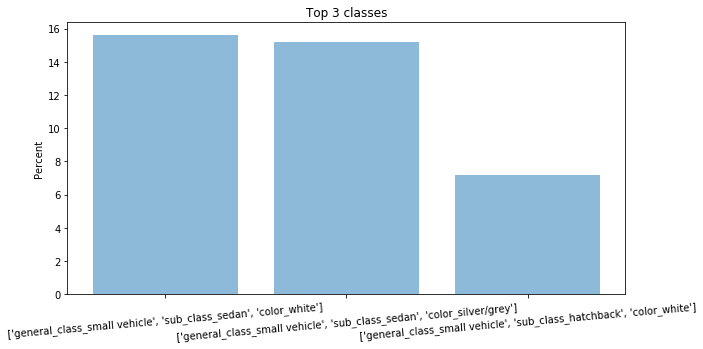

In [54]:
width = 1/1.5
plt.figure(figsize=(10,5))
plt.title("Top 3 classes")
plt.bar(y_pos,y,align='center', alpha=0.5)
plt.ylabel("Percent")
plt.xticks( y_pos,labs, rotation=5)
plt.show()
    

# Map

In [26]:
def MAP(predicted_data, true_data):
    predicted = np.swapaxes(predicted_data,0,1)
    true = np.swapaxes(true_data,0,1)
    NC = predicted.shape[0]
    result = 0
    
    
    for i in range(NC):
        result += average_precision_score(true[i],predicted[i],"weighted")
    
    result = result / NC
    
    return result

In [68]:
preds = np.empty((0,37), int)
trues = np.empty((0,37), int)
threshold = 0.5

output = []
for i in range(32):
    output.append(mask)

for batch in dataloaders['valid']:
    inputs = batch['image'].permute(0, 3, 1, 2)
    labels = batch['targets']
    #inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float) 
            
    # Append values for later calculation of accuracy
    preds = np.append(preds,[[1 if pred > threshold else 0 for pred in sample] for sample in output],axis=0)
    trues = np.append(trues,[[1 if pred > threshold else 0 for pred in sample] for sample in labels.tolist()], axis=0)



In [69]:
MAP(preds, trues)

0.08828905960755273